# Live Code 3

# Introduction

Nama: Karina Maharani Utomo
<br>
Batch: 003

Live Code 3 Phase 1 Hacktiv8 Full Time Data Science Program

Problems:
Menggunakan dataset https://www.kaggle.com/amansaxena/lifeexpectancy, buatlah model machine learning unsupervised menggunakan KMeans untuk mendeteksi kelompok negara dan jawab beberapa pertanyaan di bawah sebagai acuan analisa/cerita:

1. Pada bagian eksplorasi data, apa insight menarik yang bisa kamu ceritakan?
2. Berapa cluster yang berhasil kamu peroleh dari dataset tersebut? apakah sudah optimal? Visualisasikan hasil clustering yang kamu peroleh dengan plot 2 dimensi dimana 2 dimensi tersebut merupakan dimensi yang diperoleh dari hasil reduksi dimensi.
3. Bagaimana karakteristik dari masing-masing cluster? Bisakah kamu visualisasikan dan ceritakan?
4. Apa insight menarik yang kamu peroleh dari jawaban/analisa nomor 3?
5. Dibandingkan dengan EDA, apakah ada kesamaan dari hasil clustering yang kamu peroleh? coba ceritakan analisamu!

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

# Data Loading

In [2]:
# Loading Data

data = pd.read_csv('Life_expectancy_dataset.csv', encoding = 'latin-1')

In [3]:
# Menampilkan data

data.head()

,Rank,Country,Overall Life,Male Life,Female Life,Continent
0,1,Monaco,89.5,85.6,93.5,Europe
1,2,Japan,85.0,81.7,88.5,Asia
2,3,Singapore,85.0,82.3,87.8,Asia
3,4,Macau; China,84.5,81.6,87.6,Asia
4,5,San Marino,83.3,80.7,86.1,Europe


In [4]:
data.shape

(223, 6)

Dataset terdiri dari 223 baris dan 6 kolom

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          223 non-null    int64  
 1   Country       223 non-null    object 
 2   Overall Life  223 non-null    float64
 3   Male Life     223 non-null    float64
 4   Female Life   223 non-null    float64
 5   Continent     223 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.6+ KB


In [6]:
data.describe()

,Rank,Overall Life,Male Life,Female Life
count,223.000000,223.000000,223.000000,223.000000
mean,112.000000,72.487892,70.041704,75.019283
std,64.518731,8.459335,8.074942,8.986633
min,1.000000,50.200000,48.600000,51.000000
25%,56.500000,67.450000,64.500000,69.750000
50%,112.000000,74.900000,72.200000,77.900000
75%,167.500000,78.600000,75.850000,81.600000
max,223.000000,89.500000,85.600000,93.500000


# Data Cleaning

In [7]:
# Mengecek keberadaan data duplikat

data.duplicated().sum()

0

In [8]:
# Mengecek keberadaan missing values

data.isnull().sum()

Rank            0
Country         0
Overall Life    0
Male Life       0
Female Life     0
Continent       0
dtype: int64

Dataset tidak memiliki data duplikat maupun missing values

# Data Exploration

**Melihat persebaran data**

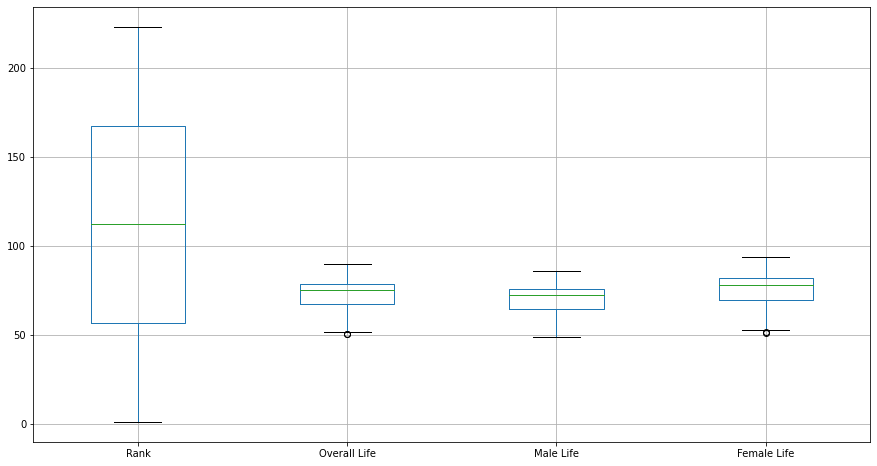

In [9]:
data.boxplot(figsize = (15,8))

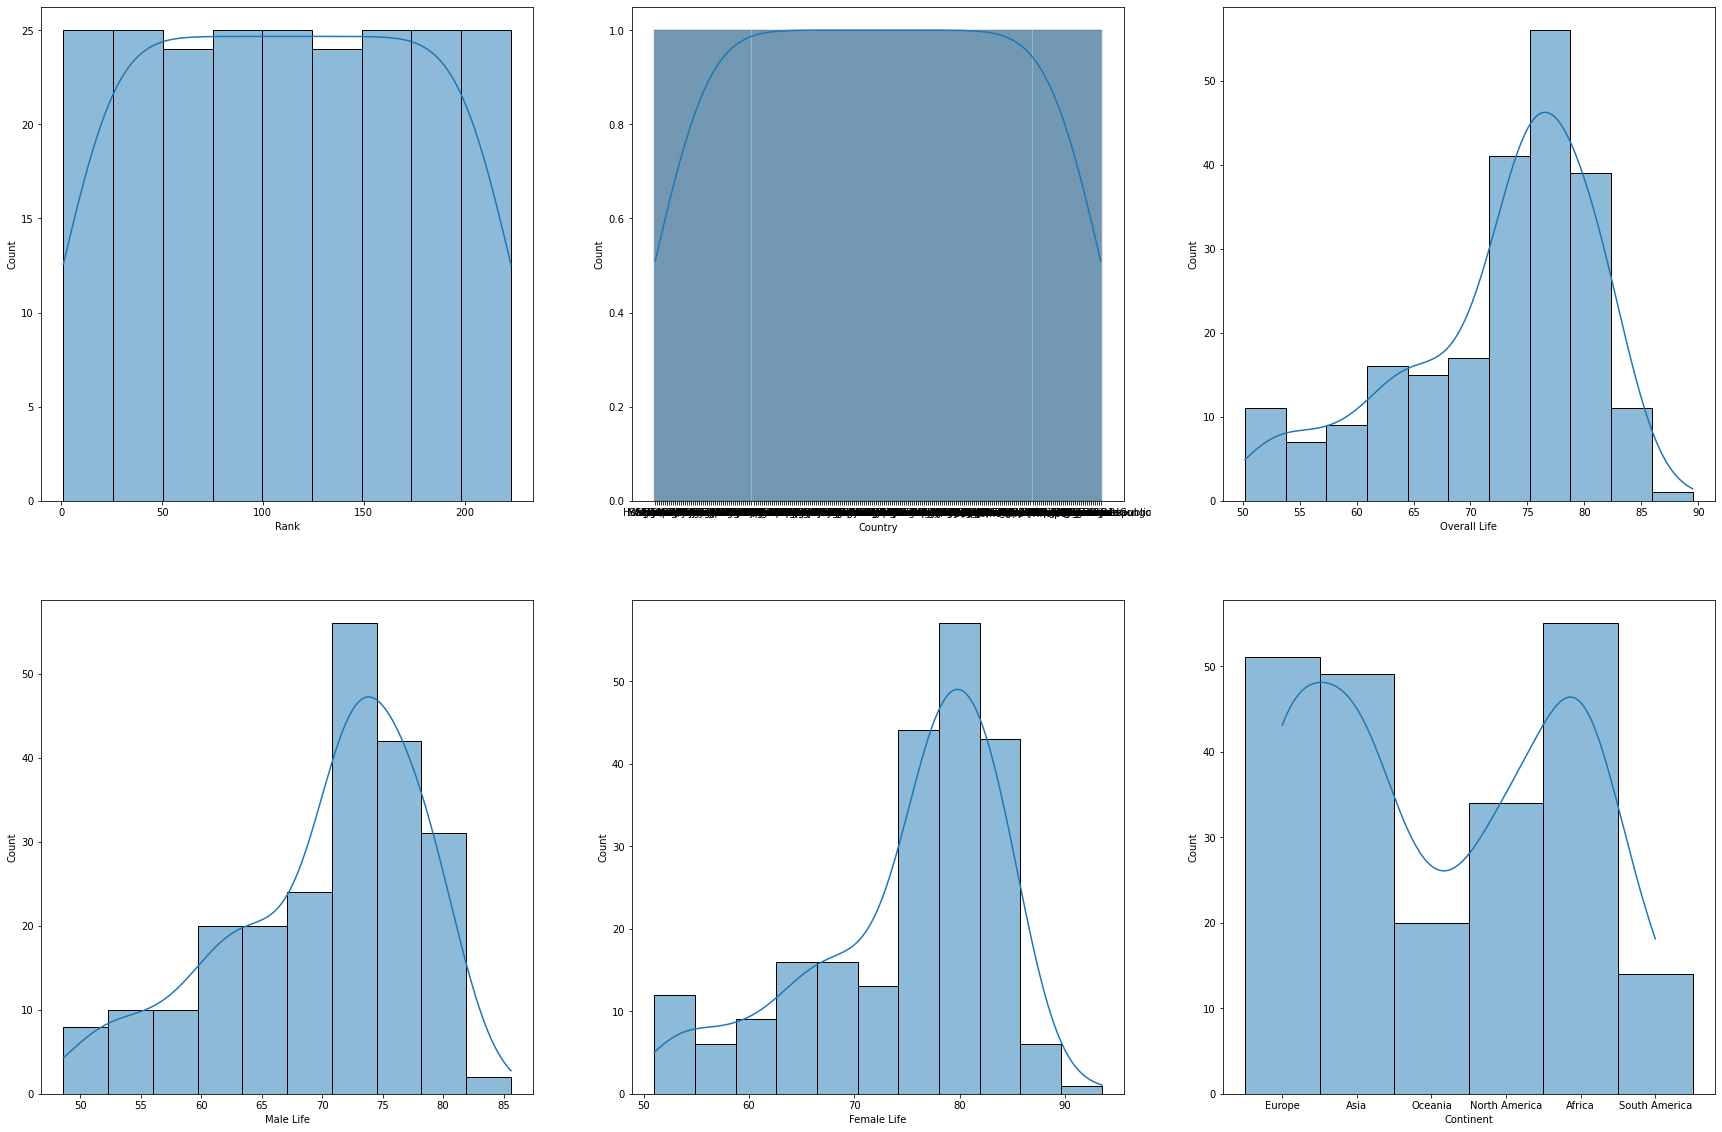

In [10]:
plt.figure(figsize=(30,20))

for i, col in enumerate(list(data.columns)):
    i += 1
    plt.subplot(2,3,i)
    sns.histplot(data = data, x = data[col], kde = True)

Dari boxplot dan plot histogram, data numerik (Overall Life, Male Life, dan Female Life) memiliki distribusi mendekati distribusi normal dan tidak ada outliers yang letaknya sangat jauh dari data

Dari plot histrogram, didapat bahwa paling banyak orang yang memiliki life expectancy hingga antara 75 - 80 tahun

**Melihat data kolom Male Life dan Female Life**

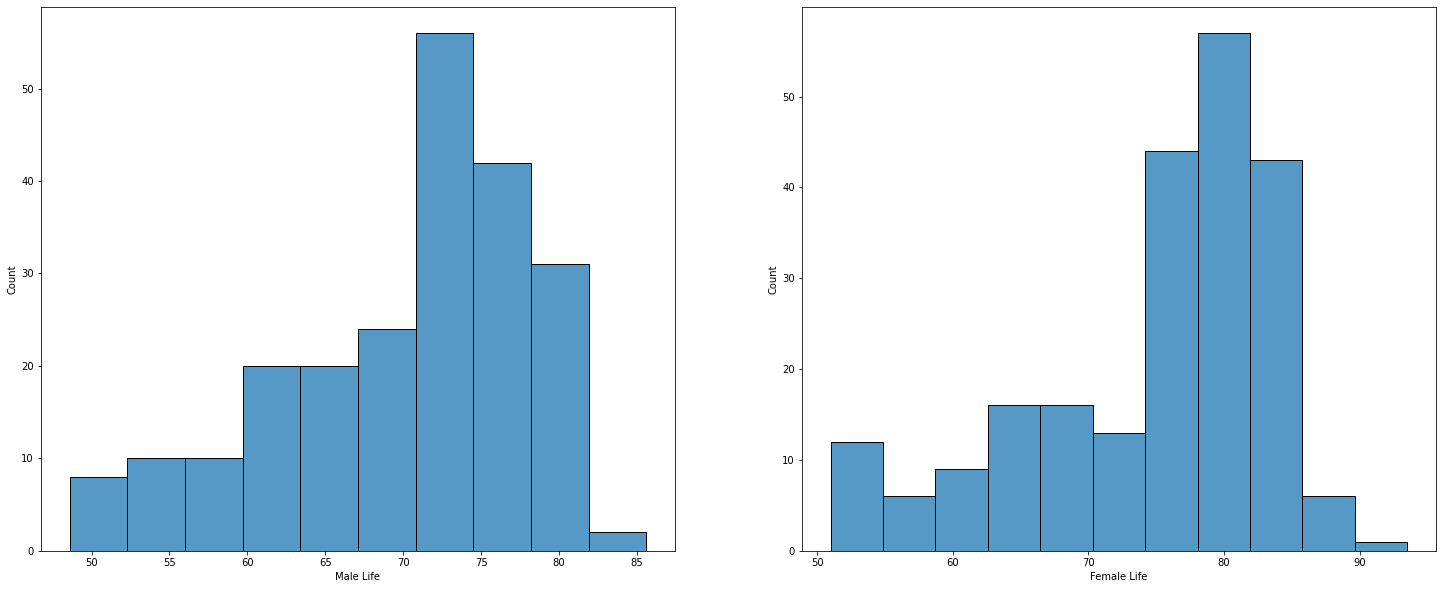

In [11]:
mf_data = data[['Male Life', 'Female Life']]

plt.figure(figsize=(25,10))

for i, col in enumerate(list(mf_data.columns)):
    i += 1
    plt.subplot(1,2,i)
    sns.histplot(data = mf_data, x = mf_data[col])

Dari plot di atas, wanita memiliki life expectancy yang lebih tinggi dibandingkan pria. Untuk pria, paling banyak memiliki life expectancy hingga antara 70-75 tahun. Sedangkan untuk wanita, paling banyak memiliki life expectancy hingga usia 80 tahun

**Melihat Overall Life per benua**

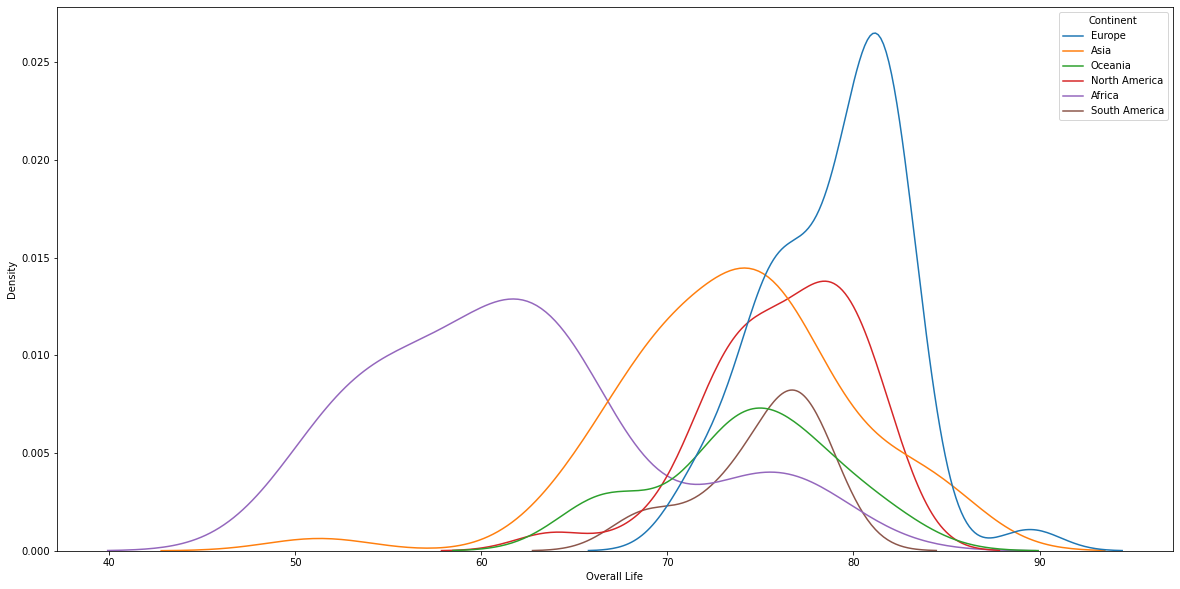

In [12]:
plt.figure(figsize=(20,10))
sns.kdeplot(data = data, x = data['Overall Life'], hue = data['Continent'])

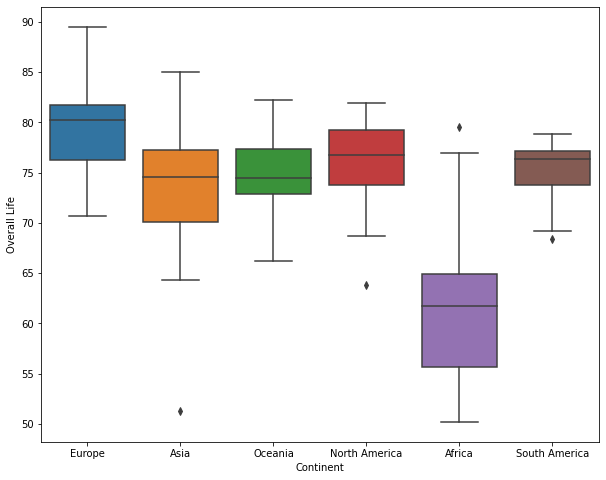

In [13]:
plt.figure(figsize=(10,8))
sns.boxplot(data = data, x = data['Continent'], y = data['Overall Life'])
plt.show()

Dari plot kde dan boxplot:
1. Masyarakat benua Eropa memiliki life expectancy yang paling tinggi, dengan
    - Life expectancy paling rendah di sekitar usia 70 tahun
    - Life expectancy paling tinggi di sekitar usia 90 tahun
2. Masyarakat benua Afrika memiliki life expectancy yang paling rendah, dengan
    - Life expectancy paling rendah di sekitar usia 55 tahun
    - Life expectancy paling tinggi di sekitar usia 77 tahun (terdapat outlier di usia 80 tahun)

# Data Preprocessing

Untuk proses clustering, hanya akan dipilih data yang bersifat numerik. Dalam kasus ini adalah kolom Overall Life, Male Life, dan Female Life

**Features Scaling**

In [14]:
# Menseleksi data untuk clustering

num_data = data[['Overall Life', 'Male Life', 'Female Life']]
num_data.head()

,Overall Life,Male Life,Female Life
0,89.5,85.6,93.5
1,85.0,81.7,88.5
2,85.0,82.3,87.8
3,84.5,81.6,87.6
4,83.3,80.7,86.1


In [15]:
# Features scaling

scaler=StandardScaler()
num_scaled = scaler.fit_transform(num_data)

**Determining n-clusters**

Untuk menentukan jumlah cluster, akan digunakan metode elbow

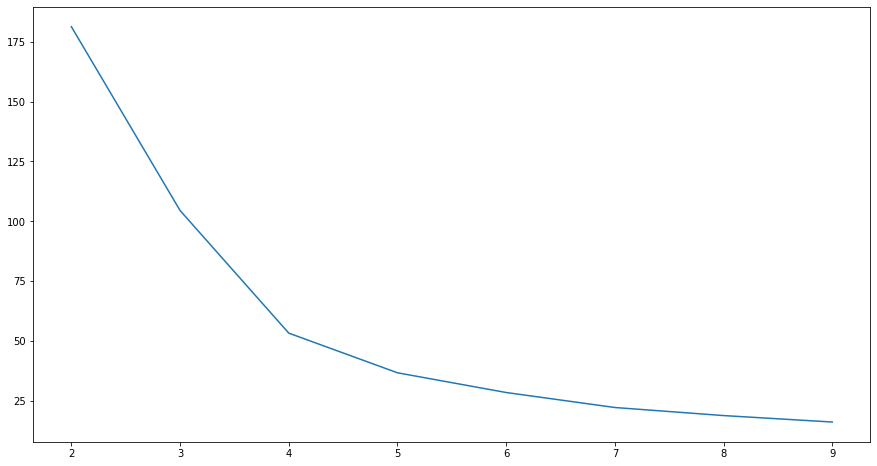

In [16]:
scores=[]
k = []

plt.figure(figsize = (15,8))
range_values=range(2,10)
for i in range_values:
    kmean=KMeans(n_clusters=i)
    kmean.fit(num_scaled)
    scores.append(kmean.inertia_)
    k.append(i)
    
plt.plot(k, scores)
plt.show()

In [17]:
# Melihat silhouette score dari masing-masing jumlah cluster

for i in range(2, 10):
    score = silhouette_score(num_scaled, KMeans(n_clusters = i).fit_predict(num_scaled))
    print(f'Silhouette score for {i} clusters:', '%.3f' % score)

Silhouette score for 2 clusters: 0.659
Silhouette score for 3 clusters: 0.508
Silhouette score for 4 clusters: 0.542
Silhouette score for 5 clusters: 0.518
Silhouette score for 6 clusters: 0.504
Silhouette score for 7 clusters: 0.470
Silhouette score for 8 clusters: 0.457
Silhouette score for 9 clusters: 0.442


Dari plot dan silhouette score, akan dipilih jumlah cluster sebanyak 4

# Model Defining

Untuk proses clustering, akan digunakan metode K-Means Clustering

In [18]:
# Model defining & training K-Means Clustering

kmeans = KMeans(4)
kmeans.fit(num_scaled)

# Output
label_km = kmeans.labels_

In [19]:
# Menggabungkan hasil clustering ke data awal

data_cluster = pd.concat([pd.DataFrame({'Cluster':label_km}), data],axis=1)
data_cluster

,Cluster,Rank,Country,Overall Life,Male Life,Female Life,Continent
0,0,1,Monaco,89.5,85.6,93.5,Europe
1,0,2,Japan,85.0,81.7,88.5,Asia
2,0,3,Singapore,85.0,82.3,87.8,Asia
3,0,4,Macau; China,84.5,81.6,87.6,Asia
4,0,5,San Marino,83.3,80.7,86.1,Europe
...,...,...,...,...,...,...,...
218,1,219,Gabon,52.1,51.6,52.5,Africa
219,1,220,Swaziland,51.6,52.2,51.0,Africa
220,1,221,Afghanistan,51.3,49.9,52.7,Asia
221,1,222,Guinea-Bissau,50.6,48.6,52.7,Africa


In [20]:
# Melihat jumlah data pada setiap cluster

data_cluster['Cluster'].value_counts()

2    90
0    68
3    41
1    24
Name: Cluster, dtype: int64

# Model Evaluation

**Visualisasi hasil clustering**

Sebelum melakukan visualisasi hasil clustering, akan dilakukan dimension reduction data menjadi 2 dimensi terlebih dahulu, menggunakan PCA

In [21]:
# Dimension reduction

pca = PCA(n_components=2)
pcafit = pca.fit_transform(num_scaled)

In [22]:
pca_data = pd.DataFrame(data = pcafit, columns = ['pca1','pca2'])
pca_data

,pca1,pca2
0,-3.468599,-0.091908
1,-2.559335,-0.039879
2,-2.557261,0.067979
3,-2.460010,0.022324
4,-2.216841,0.061627
...,...,...
218,4.166172,0.157309
219,4.253993,0.328284
220,4.329837,-0.007666
221,4.470880,-0.121758


In [23]:
# Menggabungkan hasil clustering K-Means

pca_data = pd.concat([pca_data, pd.DataFrame({'Cluster':label_km})],axis=1)

In [24]:
pca_data

,pca1,pca2,Cluster
0,-3.468599,-0.091908,0
1,-2.559335,-0.039879,0
2,-2.557261,0.067979,0
3,-2.460010,0.022324,0
4,-2.216841,0.061627,0
...,...,...,...
218,4.166172,0.157309,1
219,4.253993,0.328284,1
220,4.329837,-0.007666,1
221,4.470880,-0.121758,1


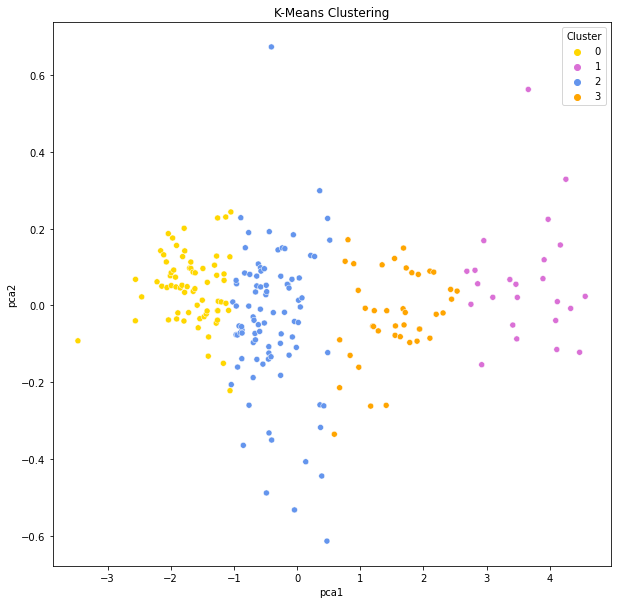

In [25]:
# Plot clustering data dengan K-Means

plt.figure(figsize=(10,10))
ax=sns.scatterplot(x='pca1',y='pca2',hue='Cluster',data=pca_data,palette=['gold', 'orchid', 'cornflowerblue', 'orange'])
plt.title ('K-Means Clustering')
plt.show()

Dari visualisasi hasil clustering, dapat dilihat bahwa data terpisah dengan jelas

**Analisis setiap cluster**

Untuk melihat karakteristik dari setiap cluster, akan dibuat plot data dari masing-masing cluster

In [26]:
# Menyiapkan data untuk proses analisis

vis_data = data_cluster.drop('Country', axis = 1)
vis_data.head()

,Cluster,Rank,Overall Life,Male Life,Female Life,Continent
0,0,1,89.5,85.6,93.5,Europe
1,0,2,85.0,81.7,88.5,Asia
2,0,3,85.0,82.3,87.8,Asia
3,0,4,84.5,81.6,87.6,Asia
4,0,5,83.3,80.7,86.1,Europe


Kolom Country diputuskan untuk dihapus untuk proses analisis karena memliki unique value yang terlalu banyak. Selain itu, kolom Country dapat diwakilkan oleh kolom Continent

In [27]:
vis_data['Cluster'].unique()

array([0, 2, 3, 1], dtype=int32)

In [28]:
# Grouping data berdasarkan cluster

cluster_0 = vis_data[vis_data['Cluster'] == 0]
cluster_1 = vis_data[vis_data['Cluster'] == 1]
cluster_2 = vis_data[vis_data['Cluster'] == 2]
cluster_3 = vis_data[vis_data['Cluster'] == 3]

Visualisasi data cluster 0

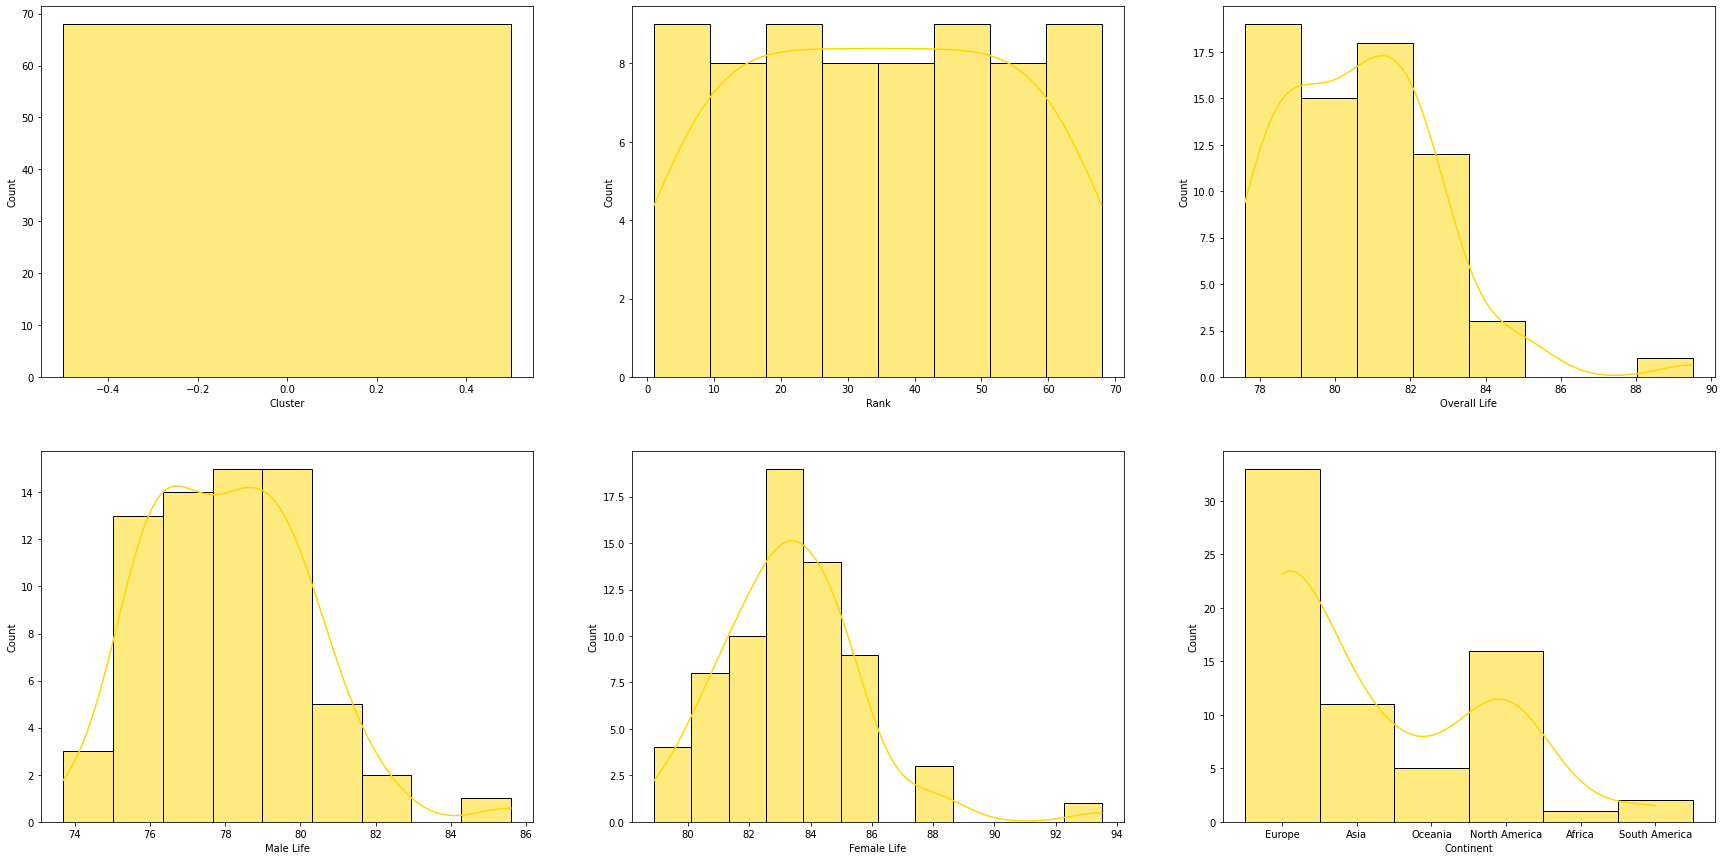

In [29]:
plt.figure(figsize=(30,15))

for i, col in enumerate(list(cluster_0.columns)):
    i += 1
    plt.subplot(2,3,i)
    sns.histplot(data = cluster_0, x = cluster_0[col], kde = True, color = 'gold')

Visualisasi data cluster 1

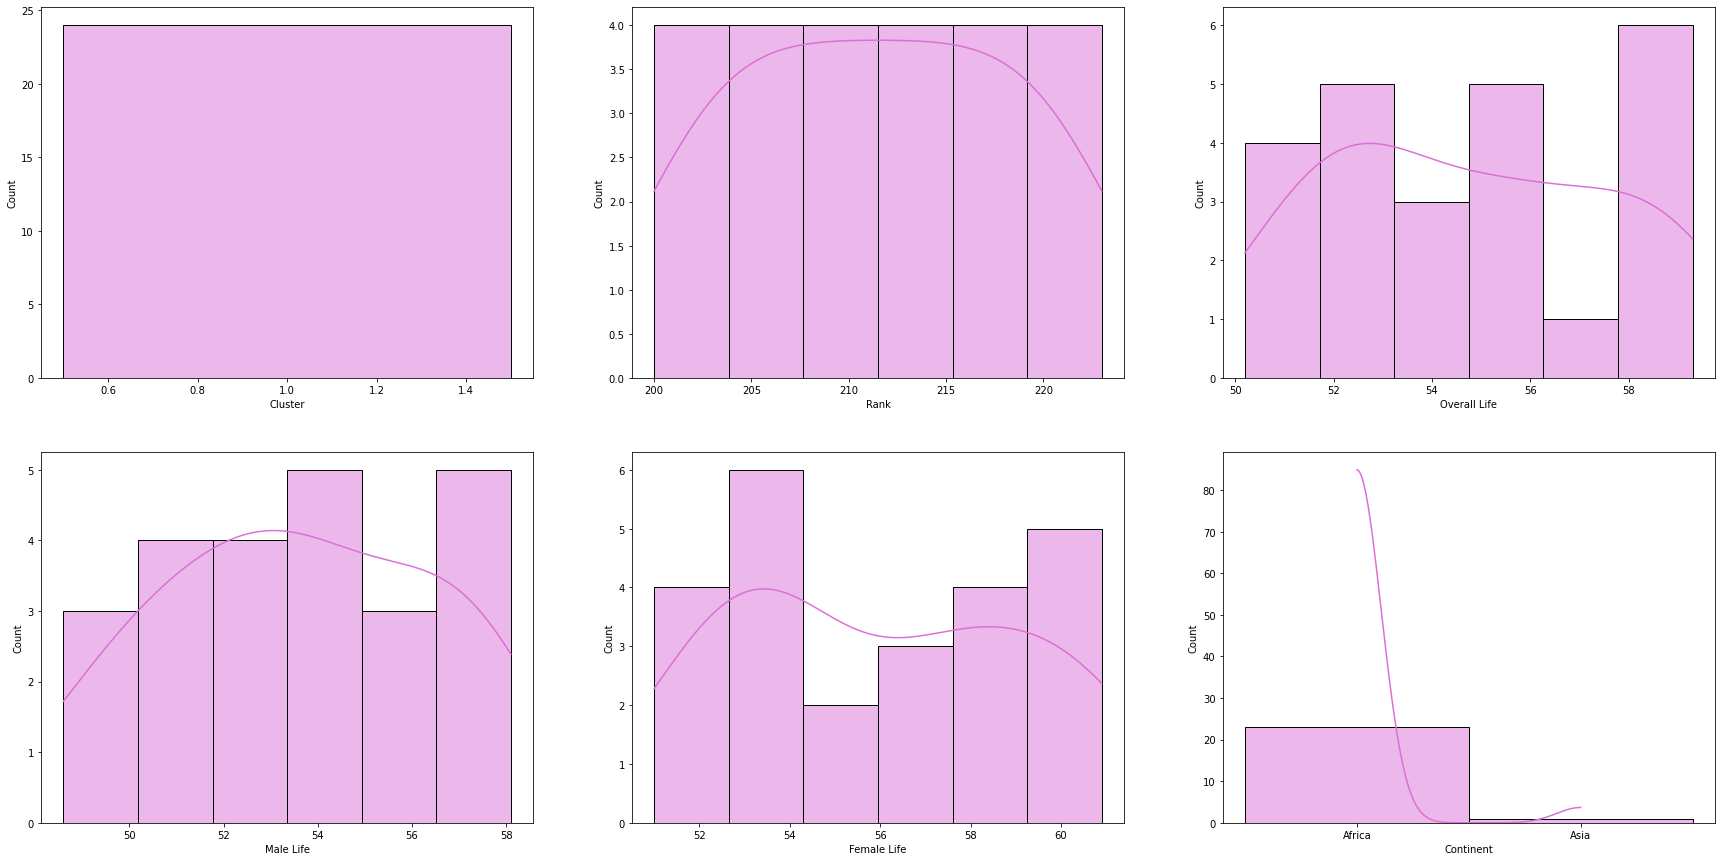

In [30]:
plt.figure(figsize=(30,15))

for i, col in enumerate(list(cluster_1.columns)):
    i += 1
    plt.subplot(2,3,i)
    sns.histplot(data = cluster_1, x = cluster_1[col], kde = True, color = 'orchid')

Visualisasi data cluster 2

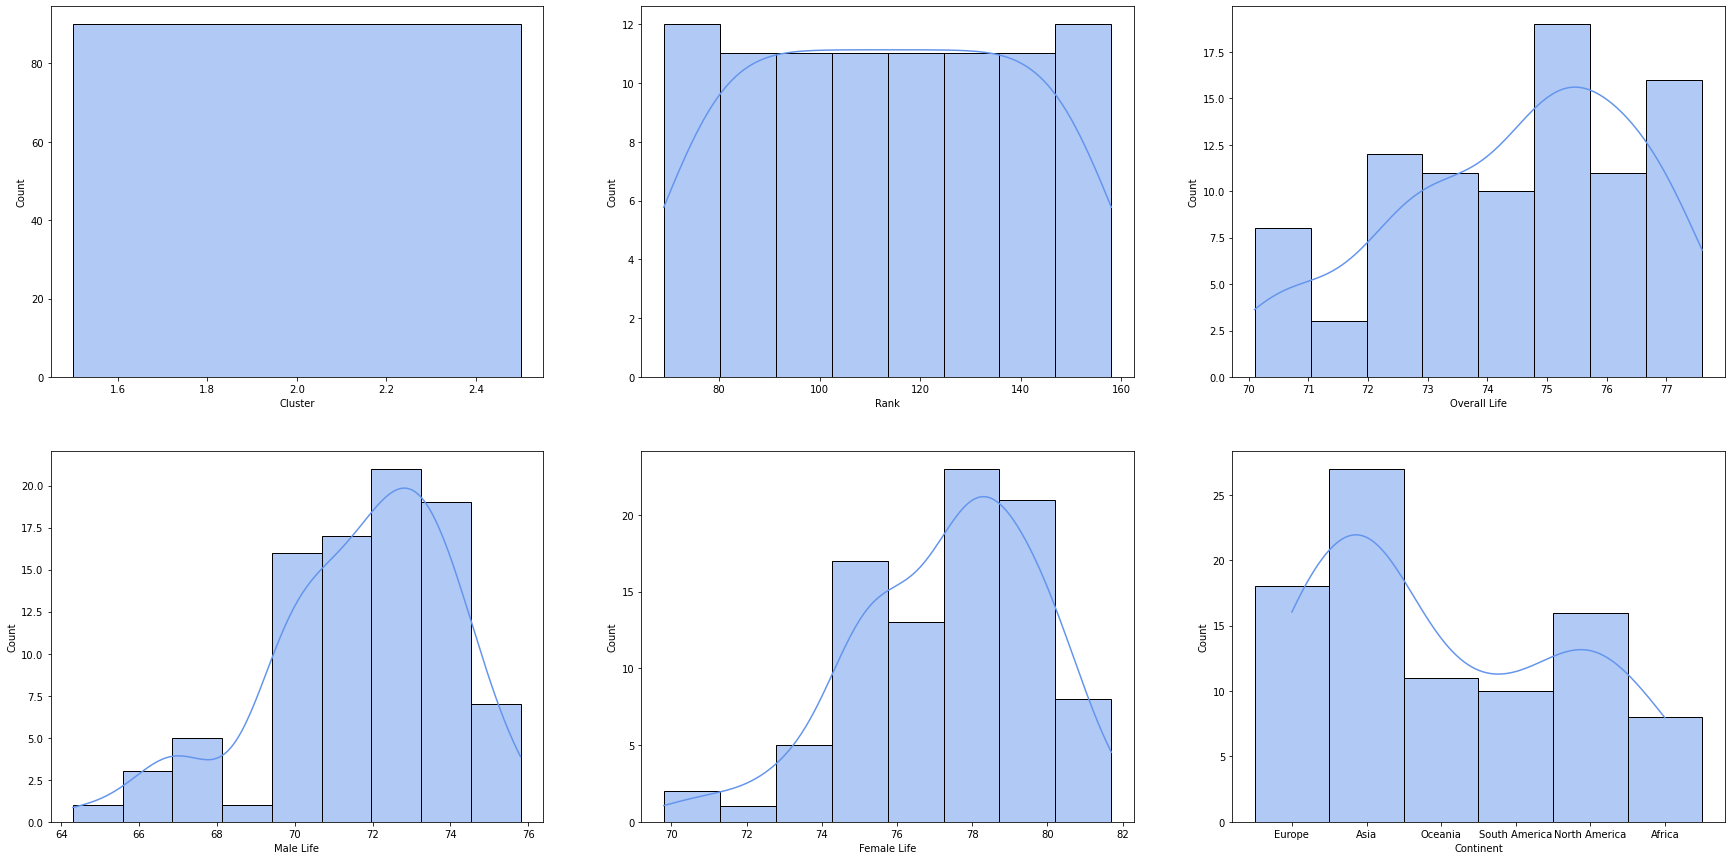

In [31]:
plt.figure(figsize=(30,15))

for i, col in enumerate(list(cluster_2.columns)):
    i += 1
    plt.subplot(2,3,i)
    sns.histplot(data = cluster_2, x = cluster_2[col], kde = True, color = 'cornflowerblue')

Visualisasi data cluster 3

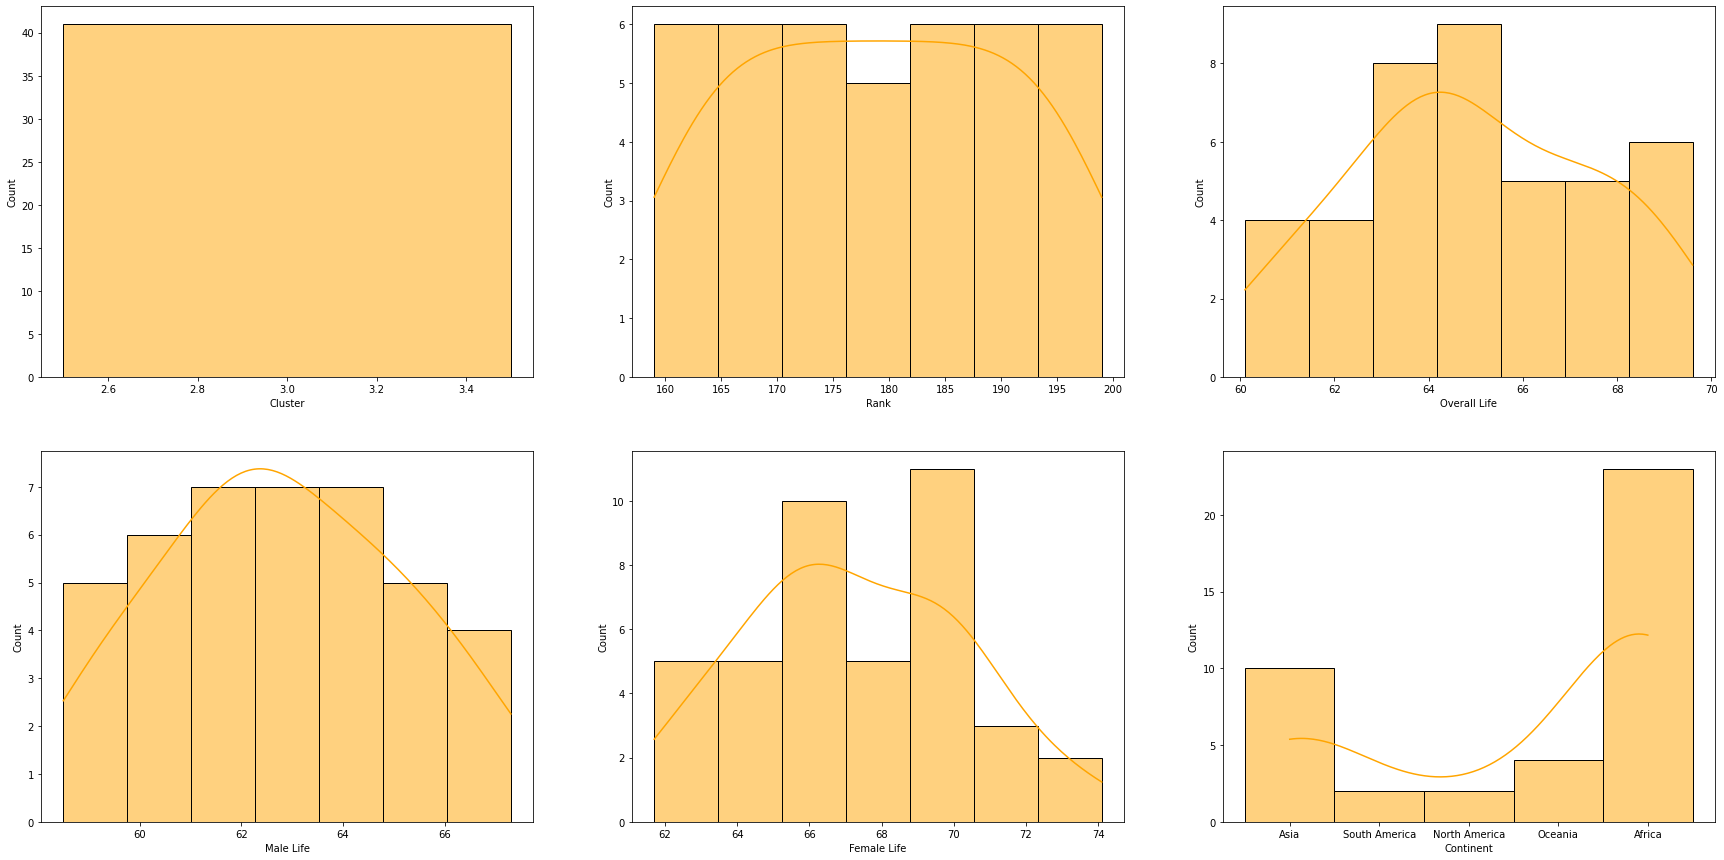

In [32]:
plt.figure(figsize=(30,15))

for i, col in enumerate(list(cluster_3.columns)):
    i += 1
    plt.subplot(2,3,i)
    sns.histplot(data = cluster_3, x = cluster_3[col], kde = True, color = 'orange')

Dari visualisasi setiap cluster, didapat bahwa:
- **Cluster 0** merupakan negara-negara dengan:
    - Ranking 1 hingga 70
    - Overall usia life expectancy antara 78 hingga mendekati 86 tahun
    - Usia life expectancy masyarakat pria antara 74 hingga 82 tahun
    - Usia life expectancy masyarakat wanita antara 79 hingga 86 tahun
    - Cluster 1 berisi negara dari semua benua, dengan data paling banyak dari negara di benua Eropa
   
- **Cluster 1** merupakan negara-negara dengan:
    - Ranking 200 hingga 220-an
    - Overall usia life expectancy antara 50 hingga 58 tahun
    - Usia life expectancy masyarakat pria antara 49 hingga 58 tahun
    - Usia life expectancy masyarakat wanita antara 52 hingga 60 tahun
    - Cluster 3 berisi negara dari benua Asia dan Afrika saja, dengan data paling banyak dari negara di benua Afrika
   
- **Cluster 2** merupakan negara-negara dengan:
    - Ranking 70 hingga 160
    - Overall usia life expectancy antara 70 hingga 77 tahun
    - Usia life expectancy masyarakat pria antara 64 hingga mendekati 76 tahun
    - Usia life expectancy masyarakat wanita antara 70 hingga mendekati 82 tahun
    - Cluster 2 berisi negara dari semua benua, dengan data paling banyak dari negara di benua Asia
   
- **Cluster 3** merupakan negara-negara dengan:
    - Ranking 160 hingga 200
    - Overall usia life expectancy antara 60 hingga mendekati 70 tahun
    - Usia life expectancy masyarakat pria antara 58 hingga 68 tahun
    - Usia life expectancy masyarakat wanita antara 62 hingga 74 tahun
    - Cluster 0 berisi negara dari semua benua, dengan data paling banyak dari negara di benua Afrika
   
Hasil dari clustering sesuai dengan apa yang didapat pada bagian EDA. Cluster yang memiliki banyak data dari benua Eropa memiliki life expectancy dan ranking yang lebih tinggi. Sebaliknya Cluster yang memiliki banyak data dari benua Afrika memiliki life expectancy dan ranking yang lebih rendah. Dari analisis cluster juga dapat dilihat bahwa pada setiap cluster, life expectancy wanita lebih tinggi dibandingkan pria

# Model Inference

Untuk model inference, akan dibuat 2 data baru yang bersifat random

In [33]:
# Menampilkan kembali data numerik

num_data.tail()

,Overall Life,Male Life,Female Life
218,52.1,51.6,52.5
219,51.6,52.2,51.0
220,51.3,49.9,52.7
221,50.6,48.6,52.7
222,50.2,49.0,51.3


In [34]:
num_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Overall Life,223.0,72.487892,8.459335,50.2,67.45,74.9,78.60,89.5
Male Life,223.0,70.041704,8.074942,48.6,64.50,72.2,75.85,85.6
Female Life,223.0,75.019283,8.986633,51.0,69.75,77.9,81.60,93.5


In [35]:
# Membuat 2 data random

num_data.loc[223] = [69.3, 68.5, 70]
num_data.loc[224] = [57, 55.7, 58.2]

/Users/karinautomo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
num_data.tail()

,Overall Life,Male Life,Female Life
220,51.3,49.9,52.7
221,50.6,48.6,52.7
222,50.2,49.0,51.3
223,69.3,68.5,70.0
224,57.0,55.7,58.2


In [37]:
# Menseleksi data random

data_random = num_data.loc[223:]
data_random

,Overall Life,Male Life,Female Life
223,69.3,68.5,70.0
224,57.0,55.7,58.2


In [38]:
# Scaling data

random_scaled = scaler.transform(data_random)

In [39]:
# Memprediksi data random tergolong dalam cluster yang mana

pred_infer = kmeans.predict(random_scaled)
pred_infer

array([3, 1], dtype=int32)

Didapat bahwa data random pertama tergolong dalam cluster 3 dan data random kedua tergolong dalam cluster 1. Hasil clustering data random sesuai dengan karakteristik masing-masing cluster

# Conclusion

Dari **Data Exploration**, didapat bahwa:
1. Paling banyak orang yang memiliki life expectancy hingga antara 75 - 80 tahun
2. Wanita memiliki life expectancy yang lebih tinggi dibandingkan pria
    - Untuk pria, paling banyak memiliki life expectancy hingga antara 70-75 tahun
    - Untuk wanita, paling banyak memiliki life expectancy hingga 80 tahun
3. Masyarakat benua Eropa memiliki life expectancy yang paling tinggi, dengan
    - Life expectancy paling rendah di sekitar usia 70 tahun
    - Life expectancy paling tinggi di sekitar usia 90 tahun
4. Masyarakat benua Afrika memiliki life expectancy yang paling rendah, dengan
    - Life expectancy paling rendah di sekitar usia 55 tahun
    - Life expectancy paling tinggi di sekitar usia 77 tahun (terdapat outlier di usia 80 tahun)
***
Untuk proses clustering, digunakan metode **K-Means Clustering dengan jumlah cluster sebanyak 4**. Jumlah cluster ditentukan dengan metode elbow. Berdasarkan plot, dipilih n-cluster dengan patahan yang paling tajam dan silhouette score yang cukup tinggi dibandingkan yang lain
***
Setelah proses clustering selesai, dilakukan visualisasi data dari masing-masing cluster untuk mempermudah proses analisis. Berikut adalah **karakteristik dari masing-masing cluster**:
- **Cluster 0** merupakan negara-negara dengan:
    - Ranking 1 hingga 70
    - Overall usia life expectancy antara 78 hingga mendekati 86 tahun
    - Usia life expectancy masyarakat pria antara 74 hingga 82 tahun
    - Usia life expectancy masyarakat wanita antara 79 hingga 86 tahun
    - Cluster 1 berisi negara dari semua benua, dengan data paling banyak dari negara di benua Eropa
   
- **Cluster 1** merupakan negara-negara dengan:
    - Ranking 200 hingga 220-an
    - Overall usia life expectancy antara 50 hingga 58 tahun
    - Usia life expectancy masyarakat pria antara 49 hingga 58 tahun
    - Usia life expectancy masyarakat wanita antara 52 hingga 60 tahun
    - Cluster 3 berisi negara dari benua Asia dan Afrika saja, dengan data paling banyak dari negara di benua Afrika
   
- **Cluster 2** merupakan negara-negara dengan:
    - Ranking 70 hingga 160
    - Overall usia life expectancy antara 70 hingga 77 tahun
    - Usia life expectancy masyarakat pria antara 64 hingga mendekati 76 tahun
    - Usia life expectancy masyarakat wanita antara 70 hingga mendekati 82 tahun
    - Cluster 2 berisi negara dari semua benua, dengan data paling banyak dari negara di benua Asia
   
- **Cluster 3** merupakan negara-negara dengan:
    - Ranking 160 hingga 200
    - Overall usia life expectancy antara 60 hingga mendekati 70 tahun
    - Usia life expectancy masyarakat pria antara 58 hingga 68 tahun
    - Usia life expectancy masyarakat wanita antara 62 hingga 74 tahun
    - Cluster 0 berisi negara dari semua benua, dengan data paling banyak dari negara di benua Afrika
   
**Hasil dari clustering sesuai dengan apa yang didapat pada bagian Data Exploration**. Cluster yang memiliki banyak data dari benua Eropa memiliki life expectancy dan ranking yang lebih tinggi. Sebaliknya Cluster yang memiliki banyak data dari benua Afrika memiliki life expectancy dan ranking yang lebih rendah. Dari analisis cluster juga dapat dilihat bahwa pada setiap cluster, life expectancy wanita lebih tinggi dibandingkan pria
***
Pada **Model Inference**, dibuat 2 data baru, secara random, sebagai berikut:
1. Data pertama
    - Overall Life: 69.3
    - Male Life: 68.5
    - Female Life: 70
2. Data kedua
    - Overall Life: 57
    - Male Life: 55.7
    - Female Life: 58.2

Didapat bahwa data random pertama tergolong dalam cluster 3 dan data random kedua tergolong dalam cluster 1. **Hasil clustering data random sesuai dengan karakteristik dari masing-masing cluster**